In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
cd ./drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments/Datasets

/content/drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments/Datasets


### Import Packaged and Load Original Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

# import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('./new_data_set.csv', parse_dates=['intervalStart'])
df = df.set_index('intervalStart')

### Data Preparation: Feature Engineering
#### - Add holidays
#### - Add lag features
#### - Delete programs related features

In [ ]:
# add holidays
import holidays
from datetime import datetime

df_modified = df.copy(deep=True)


df_modified['hols'] = pd.Series(df.index).apply(lambda x: holidays.CountryHoliday('US',prov='MN').get(x)).values


def non_holi(x):

  if x['hols'] == None:
    return 0

  else:
    return 1



df_modified['hols'] = df_modified.apply(non_holi, axis=1)


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label = le.fit_transform(df_modified['hols'])
df_modified['hols'] = label



# add lag features
target_map = df_modified['Connexus_kWh'].to_dict()


def add_legs(df):

  temp_df = df.copy(deep=True)

  temp_df['lag1'] = (temp_df.index - pd.Timedelta('364 days')).map(target_map)
  temp_df['lag2'] = (temp_df.index - pd.Timedelta('728 days')).map(target_map)
  temp_df['lag3'] = (temp_df.index - pd.Timedelta('1092 days')).map(target_map)

  return temp_df


df_modified = add_legs(df_modified)


# add time related features
def create_features(df):
  """
  Creates time series features from datetime index
  """

  temp_df = df.copy(deep=True)



  # temp_df['hour'] = temp_df.index.hour
  # temp_df['dayofweek'] = temp_df.index.dayofweek
  # temp_df['quarter'] = temp_df.index.quarter
  # temp_df['month'] = temp_df.index.month
  # temp_df['year'] = temp_df.index.year
  # temp_df['dayofyear'] = temp_df.index.dayofyear
  # temp_df['weekofyear'] = temp_df.index.weekofyear
  # temp_df['dayofmonth'] = temp_df.index.day
  # temp_df['weekofyear'] = temp_df.index.isocalendar().week

  for i in temp_df.columns:
    if '_mins' in i:
      temp_df = temp_df.drop(columns = [i])

  return temp_df


df_modified = create_features(df_modified)

### Train Using Cross Validation

In [ ]:
df_modified_train_val = df_modified[df_modified['year']<=2022]
df_modified_test = df_modified[df_modified['year']==2023]

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

tss = TimeSeriesSplit(n_splits=3, test_size = 24*365*1, gap=24)

X_train = df_modified_train_val.drop('Connexus_kWh', axis=1)
y_train = df_modified_train_val['Connexus_kWh']

X_test = df_modified_test[-8760:].drop('Connexus_kWh', axis=1)
y_test = df_modified_test[-8760:]['Connexus_kWh']

model = lgb.LGBMRegressor()

parameters = {
    'max_depth': sp_randint(15, 100),
    'num_leaves': sp_randint(10, 100),
    'learning_rate':sp_uniform(0.001, 0.01),
    'n_estimators':[5000],
    'feature_fraction':sp_uniform(0.1, 1),
    'bagging_fraction':sp_uniform(0.1, 1),
    'bagging_freq':sp_randint(0, 10),
    'min_data_in_leaf':sp_randint(10, 200),
    'verbose':[-1]
}

grid_search = RandomizedSearchCV(estimator=model, cv=tss, param_distributions=parameters, verbose=100, scoring='neg_root_mean_squared_error', n_iter=100)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3; 1/100] START bagging_fraction=0.4865144438465534, bagging_freq=9, feature_fraction=0.2645603397907438, learning_rate=0.0024722576966635873, max_depth=81, min_data_in_leaf=165, n_estimators=5000, num_leaves=55, verbose=-1
[CV 1/3; 1/100] END bagging_fraction=0.4865144438465534, bagging_freq=9, feature_fraction=0.2645603397907438, learning_rate=0.0024722576966635873, max_depth=81, min_data_in_leaf=165, n_estimators=5000, num_leaves=55, verbose=-1;, score=-17299.951 total time=  20.0s
[CV 2/3; 1/100] START bagging_fraction=0.4865144438465534, bagging_freq=9, feature_fraction=0.2645603397907438, learning_rate=0.0024722576966635873, max_depth=81, min_data_in_leaf=165, n_estimators=5000, num_leaves=55, verbose=-1
[CV 2/3; 1/100] END bagging_fraction=0.4865144438465534, bagging_freq=9, feature_fraction=0.2645603397907438, learning_rate=0.0024722576966635873, max_depth=81, min_data_in_leaf=165, n_estimators=5000, num_leave

RandomizedSearchCV(cv=TimeSeriesSplit(gap=24, max_train_size=None, n_splits=3, test_size=8760),
                   estimator=LGBMRegressor(), n_iter=100,
                   param_distributions={'bagging_fraction': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c4f7f7d9120>,
                                        'bagging_freq': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c4f7f7d8d30>,
                                        'feature_f...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c4f7f7dac80>,
                                        'min_data_in_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c4f7f7d9750>,
                                        'n_estimators': [5000],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c4f7f7d8f70>,
                                        'verbose': [-1]},
                   scoring='neg_root_mean_squared_error', verbose=100)

In [ ]:
grid_search.best_params_

{'bagging_fraction': 0.43754956760471697,
 'bagging_freq': 9,
 'feature_fraction': 0.6435932149463338,
 'learning_rate': 0.003511204984027794,
 'max_depth': 17,
 'min_data_in_leaf': 56,
 'n_estimators': 5000,
 'num_leaves': 60,
 'verbose': -1}

### Forecast on Test

In [ ]:
# test['prediction'] = reg.predict(X_test)
test = df_modified[df_modified['year']==2023]
test['prediction'] = grid_search.predict(X_test)

In [ ]:
df_modified_merged = df_modified.merge(test[['prediction']], how='left', left_index=True, right_index=True)

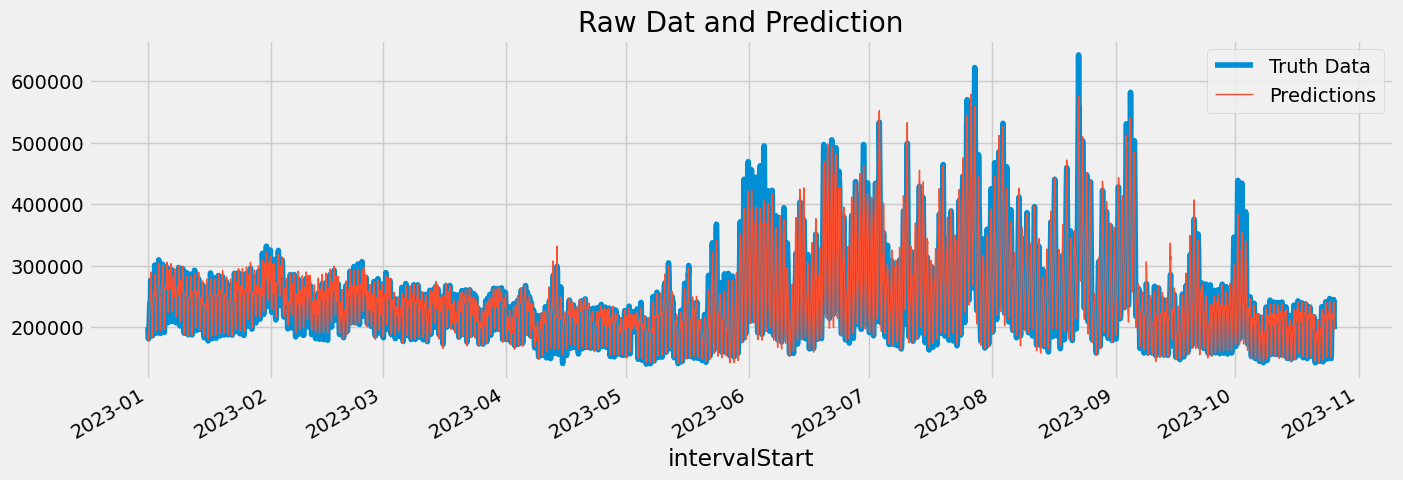

In [ ]:
ax = df_modified_merged[df_modified_merged['year']==2023][['Connexus_kWh']].plot(figsize=(15, 5))
df_modified_merged[df_modified_merged['year']==2023]['prediction'].plot(ax=ax, lw=1)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

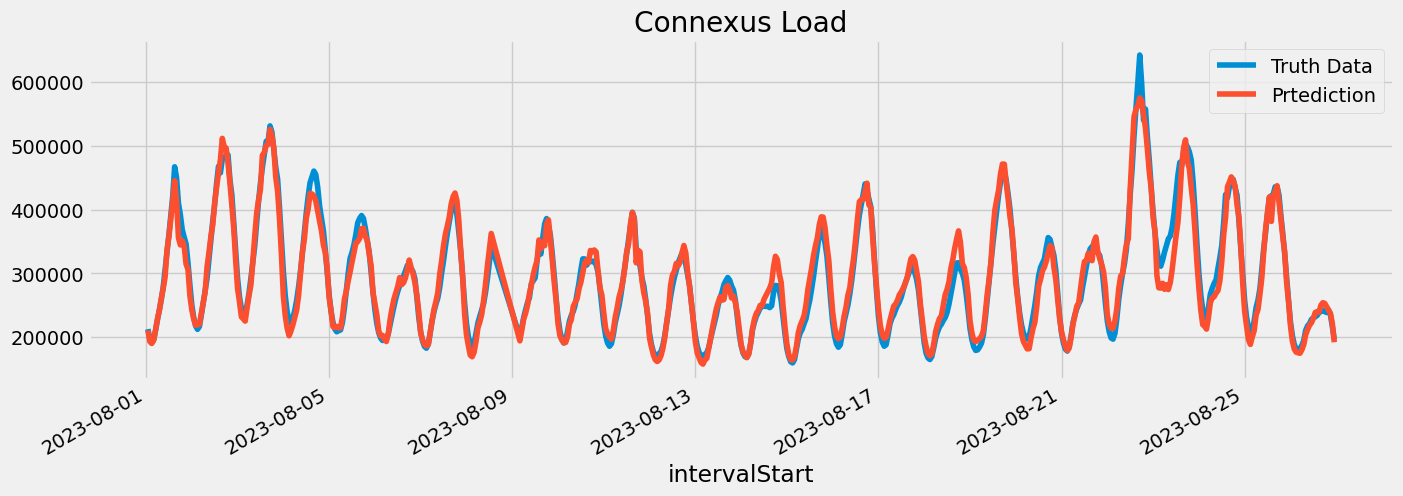

In [ ]:
ax = df_modified_merged.loc[(df_modified_merged.index > '2023-08-01') & (df_modified_merged.index < '2023-08-27')].plot(y='Connexus_kWh', figsize=(15, 5), title='Connexus Load')
df_modified_merged.loc[(df_modified_merged.index > '2023-08-01') & (df_modified_merged.index < '2023-08-27')].plot(y='prediction', ax=ax)
plt.legend(['Truth Data', 'Prtediction'])
plt.show()

In [ ]:
np.sqrt(mean_squared_error(test['Connexus_kWh'], test['prediction']))

14924.023511789637

In [ ]:
from google.colab import files
import io

uploaded = files.upload()

In [ ]:
df_future = pd.read_csv('./weather_predictions_df.csv', parse_dates=['intervalStart'])
df_future = df_future.drop(['Unnamed: 0'], axis=1)
df_future = df_future.set_index('intervalStart')

file = './weather_predictions_df.csv'

if(os.path.exists(file) and os.path.isfile(file)):
  os.remove(file)
  print("file deleted")
else:
  print("file not found")

In [ ]:
df_future.head()

In [ ]:
df_future['isFuture'] = True
df_modified_merged['isFuture'] = False

df_and_future = pd.concat([df_modified_merged, df_future])
df_and_future = create_features(df_and_future)
df_and_future['hols'] = pd.Series(df_and_future.index).apply(lambda x: holidays.CountryHoliday('US',prov='MN').get(x)).values
df_and_future['hols'] = df_and_future.apply(non_holi, axis=1)
df_and_future = add_legs(df_and_future)

In [ ]:
df_modified_merged.columns

In [ ]:
FEATURES = ['unixTime', 'latitude', 'longitude', 'station', 'apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'icon', 'precipAccumulation', 'precipIntensity', 'precipProbability', 'precipType', 'pressure', 'snowAccumulation', 'snowIntensity', 'temperature', 'uvIndex', 'visibility', 'windBearing', 'windGust', 'windSpeed', 'hols', 'lag1', 'lag2', 'lag3', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'weekofyear', 'dayofmonth']

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()


In [ ]:
future_w_features['pred'] = grid_search.predict(future_w_features[FEATURES])


In [ ]:
df_modified_merged[['Connexus_kWh']].tail()

In [ ]:
future_w_features[['pred']].head()

In [ ]:
future_w_features['pred'].plot(figsize=(10,5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Predictions')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7), sharex = True)

df_modified_merged[(df_modified_merged['year']==2023) & (df_modified_merged['month']==10)].plot(ax = ax, y='Connexus_kWh', label='Training_set', title='Connexus Load')
future_w_features.plot(ax=ax, y='pred', label='Test_set')

ax.title.set_size(10)

plt.show()

### Future Work with XGBoost model

- Build MLOps(Machine Learning Operations):
  Automate: train with upadated data -> test -> predictions (ex. produce dashboard)
- Add more features (ex, changes of the number of members...)
- Run the model with other station data (STF, HIB ...)
- Hyperparameter setting
- Observing load difference between normal days and holidays for each season.
- train/test with data seperated depends on the type of the member.